# Language Translation
In this project, you’re going to take a peek into the realm of neural network machine translation.  You’ll be training a sequence to sequence model on a dataset of English and French sentences that can translate new sentences from English to French.
## Get the Data
Since translating the whole language of English to French will take lots of time to train, we have provided you with a small portion of the English corpus.

In [59]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper
import problem_unittests as tests

source_path = 'data/small_vocab_en'
target_path = 'data/small_vocab_fr'
source_text = helper.load_data(source_path)
target_text = helper.load_data(target_path)

## Explore the Data
Play around with view_sentence_range to view different parts of the data.

In [60]:
view_sentence_range = (0, 10)

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

print('Dataset Stats')
print('Roughly the number of unique words: {}'.format(len({word: None for word in source_text.split()})))

sentences = source_text.split('\n')
word_counts = [len(sentence.split()) for sentence in sentences]
print('Number of sentences: {}'.format(len(sentences)))
print('Average number of words in a sentence: {}'.format(np.average(word_counts)))

print()
print('English sentences {} to {}:'.format(*view_sentence_range))
print('\n'.join(source_text.split('\n')[view_sentence_range[0]:view_sentence_range[1]]))
print()
print('French sentences {} to {}:'.format(*view_sentence_range))
print('\n'.join(target_text.split('\n')[view_sentence_range[0]:view_sentence_range[1]]))

Dataset Stats
Roughly the number of unique words: 227
Number of sentences: 137861
Average number of words in a sentence: 13.225277634719028

English sentences 0 to 10:
new jersey is sometimes quiet during autumn , and it is snowy in april .
the united states is usually chilly during july , and it is usually freezing in november .
california is usually quiet during march , and it is usually hot in june .
the united states is sometimes mild during june , and it is cold in september .
your least liked fruit is the grape , but my least liked is the apple .
his favorite fruit is the orange , but my favorite is the grape .
paris is relaxing during december , but it is usually chilly in july .
new jersey is busy during spring , and it is never hot in march .
our least liked fruit is the lemon , but my least liked is the grape .
the united states is sometimes busy during january , and it is sometimes warm in november .

French sentences 0 to 10:
new jersey est parfois calme pendant l' automne 

## Implement Preprocessing Function
### Text to Word Ids
As you did with other RNNs, you must turn the text into a number so the computer can understand it. In the function `text_to_ids()`, you'll turn `source_text` and `target_text` from words to ids.  However, you need to add the `<EOS>` word id at the end of each sentence from `target_text`.  This will help the neural network predict when the sentence should end.

You can get the `<EOS>` word id by doing:
```python
target_vocab_to_int['<EOS>']
```
You can get other word ids using `source_vocab_to_int` and `target_vocab_to_int`.

In [61]:
# ref:  http://localhost:8889/notebooks/sentiment-rnn/Sentiment_RNN_Solution.ipynb

def text_to_ids_subroutine(text, vocab2ids, target = False):
    """
    Convert source text to proper word ids, if target is True we add an end of sentence marker EOS
    :param text: String that contains all the source text.
    :param vocab2ids: Dictionary to go from the source words to an id
    :return: A lists (source_id_text)
    """


    id_text = [] # sentences, a list of sentences 

    for sentences in text.split('\n'):

        id_sentence = [] # list of word id integers in one sentence, e.g. 1, 2, 3
        for word in sentences.split():
            id_sentence.append(vocab2ids[word])
        if target:
            id_sentence.append(vocab2ids['<EOS>']) # finish with the EOS token
        id_text.append(id_sentence)
    
    return id_text

def text_to_ids(source_text, target_text, source_vocab_to_int, target_vocab_to_int):
    """
    Convert source and target text to proper word ids
    :param source_text: String that contains all the source text.
    :param target_text: String that contains all the target text.
    :param source_vocab_to_int: Dictionary to go from the source words to an id
    :param target_vocab_to_int: Dictionary to go from the target words to an id
    :return: A tuple of lists (source_id_text, target_id_text)
    """
    # TODO: Implement Function

    #let's add <EOS> for end of sentence to each sentence
#    source_ids = text_to_ids_subroutine(source_text, source_vocab_to_int)
    
    # Now let us repeat for the target
#    target_ids = text_to_ids_subroutine(target_text, target_vocab_to_int, True)
    
    
    # '.'   id = 31
    # 'and' is 4
    # ','   is 4
    
    # better approach as advised by my code reviewing tutor...  :)
    target_ids = [[target_vocab_to_int[w] for w in s.split()] + [target_vocab_to_int['<EOS>']] for s in target_text.split('\n')]
    source_ids = [[source_vocab_to_int[w] for w in s.split()] for s in source_text.split('\n')]
    
    return source_ids, target_ids

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_text_to_ids(text_to_ids)

Tests Passed


### Preprocess all the data and save it
Running the code cell below will preprocess all the data and save it to file.

In [62]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
helper.preprocess_and_save_data(source_path, target_path, text_to_ids)

# Check Point
This is your first checkpoint. If you ever decide to come back to this notebook or have to restart the notebook, you can start from here. The preprocessed data has been saved to disk.

In [63]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np
import helper

(source_int_text, target_int_text), (source_vocab_to_int, target_vocab_to_int), _ = helper.load_preprocess()

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [64]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) in [LooseVersion('1.0.0'), LooseVersion('1.0.1')], 'This project requires TensorFlow version 1.0  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


## Build the Neural Network
You'll build the components necessary to build a Sequence-to-Sequence model by implementing the following functions below:
- `model_inputs`
- `process_decoding_input`
- `encoding_layer`
- `decoding_layer_train`
- `decoding_layer_infer`
- `decoding_layer`
- `seq2seq_model`

### Input
Implement the `model_inputs()` function to create TF Placeholders for the Neural Network. It should create the following placeholders:

- Input text placeholder named "input" using the TF Placeholder name parameter with rank 2.
- Targets placeholder with rank 2.
- Learning rate placeholder with rank 0.
- Keep probability placeholder named "keep_prob" using the TF Placeholder name parameter with rank 0.

Return the placeholders in the following the tuple (Input, Targets, Learing Rate, Keep Probability)

In [65]:
def model_inputs():
    """
    Create TF Placeholders for input, targets, and learning rate.
    :return: Tuple (input, targets, learning rate, keep probability)
    """
    # TODO: Implement Function
    input_data = tf.placeholder(tf.int32, [None, None], name='input')
    targets = tf.placeholder(tf.int32, [None, None], name='targets')
    lr = tf.placeholder(tf.float32, name='lr')
    kp = tf.placeholder(tf.float32, name='keep_prob')

    return input_data, targets, lr, kp

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Process Decoding Input
Implement `process_decoding_input` using TensorFlow to remove the last word id from each batch in `target_data` and concat the GO ID to the beginning of each batch.

In [66]:
def process_decoding_input(target_data, target_vocab_to_int, batch_size):
    """
    Preprocess target data for dencoding
    :param target_data: Target Placehoder
    :param target_vocab_to_int: Dictionary to go from the target words to an id
    :param batch_size: Batch Size
    :return: Preprocessed target data
    """
    # TODO: Implement Function

    # Process the input we'll feed to the decoder
    ending = tf.strided_slice(target_data, [0, 0], [batch_size, -1], [1, 1])
    
    # in seq2seq/sequence_to_sequence_implementation.ipynb they use <s> for the special word for process decoding input
    # we add GO  to indicate targets training the batch is starting.
    dec_input = tf.concat([tf.fill([batch_size, 1], target_vocab_to_int['<GO>']), ending], 1)
    
    ############
    # TESTING #
    ##########
    '''
    # sequence_length sholud be max length of a sentence, for this unit it is the shape of the tensforflow placeholder
    #print(help(target_data))
    sequence_length = int((target_data.shape)[1])
    demonstration_outputs = np.reshape(range(batch_size * sequence_length), (batch_size, sequence_length))
    sess = tf.InteractiveSession()
    print("Targets")
    print(demonstration_outputs[:2])
    print("\n")
    print("Processed Decoding Input")
    print(sess.run(dec_input, {target_data: demonstration_outputs})[:2])
    '''
  
    return dec_input


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_process_decoding_input(process_decoding_input)

Tests Passed


### Encoding
Implement `encoding_layer()` to create a Encoder RNN layer using [`tf.nn.dynamic_rnn()`](https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn).

In [67]:
def encoding_layer(rnn_inputs, rnn_size, num_layers, keep_prob):
    """
    Create encoding layer
    :param rnn_inputs: Inputs for the RNN
    :param rnn_size: RNN Size
    :param num_layers: Number of layers
    :param keep_prob: Dropout keep probability
    :return: RNN state
    """
    # TODO: Implement Function
    
    # Encoder embedding
    # Embed the input data using tf.contrib.layers.embed_sequence
    #enc_embed_input = tf.contrib.layers.embed_sequence(input_data, source_vocab_size, encoding_embedding_size)
    
    # Pass the embedded input into a stack of RNNs. Save the RNN state and ignore the output.
    # <---- GRUs are easier to understand and less complex than LSTM, 
    # but unit test fails with them
    # ref: http://web.stanford.edu/class/cs20si/lectures/slides_11.pdf
    # ref: https://www.tensorflow.org/api_docs/python/tf/contrib/rnn/GRUCell
    #cell = tf.contrib.rnn.GRUCell(rnn_size)
    #cell = tf.contrib.rnn.core_rnn_cell.GRUCell(rnn_size)
    cell = tf.contrib.rnn.BasicLSTMCell(rnn_size)
    
    # add a drop out wrapper
    cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=keep_prob)
    
    # add cell with drop out wrapper to the stack of RNN Cells
    enc_cell = tf.contrib.rnn.MultiRNNCell([cell] * num_layers)
    
    
    #enc_cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicLSTMCell(rnn_size)] * num_layers)
    
    # output is a pair (output and state), we only want state
    output, enc_state = tf.nn.dynamic_rnn(enc_cell, rnn_inputs, dtype=tf.float32)
    
    # adding in a dropout_keep_probability
    #output = tf.nn.dropout(output, keep_prob)  #<---- not being used....!

    return enc_state

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_encoding_layer(encoding_layer)

Tests Passed


### Decoding - Training
Create training logits using [`tf.contrib.seq2seq.simple_decoder_fn_train()`](https://www.tensorflow.org/api_docs/python/tf/contrib/seq2seq/simple_decoder_fn_train) and [`tf.contrib.seq2seq.dynamic_rnn_decoder()`](https://www.tensorflow.org/api_docs/python/tf/contrib/seq2seq/dynamic_rnn_decoder).  Apply the `output_fn` to the [`tf.contrib.seq2seq.dynamic_rnn_decoder()`](https://www.tensorflow.org/api_docs/python/tf/contrib/seq2seq/dynamic_rnn_decoder) outputs.

In [68]:
def decoding_layer_train(encoder_state, dec_cell, dec_embed_input, sequence_length, decoding_scope,
                         output_fn, keep_prob):
    """
    Create a decoding layer for training
    :param encoder_state: Encoder State
    :param dec_cell: Decoder RNN Cell
    :param dec_embed_input: Decoder embedded input
    :param sequence_length: Sequence Length
    :param decoding_scope: TenorFlow Variable Scope for decoding
    :param output_fn: Function to apply the output layer
    :param keep_prob: Dropout keep probability
    :return: Train Logits
    """
    # TODO: Implement Function
    
    # Training Decoder
    train_decoder_fn = tf.contrib.seq2seq.simple_decoder_fn_train(encoder_state)
    train_pred, _, _ = tf.contrib.seq2seq.dynamic_rnn_decoder(
        dec_cell, train_decoder_fn, dec_embed_input, sequence_length, scope=decoding_scope)
    
    # Apply output function
    train_logits =  output_fn(train_pred)
    
    #apply drop out again
    # IMPROVEMENT NOTE from tutor ----
    # ut dropout layer should be within the model, 
    # not at the output, to provide improvement. Here this is like you removed words, and/or swap some.
#    train_logits = tf.nn.dropout(train_logits, keep_prob)
    
    return train_logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_decoding_layer_train(decoding_layer_train)

Tests Passed


### Decoding - Inference
Create inference logits using [`tf.contrib.seq2seq.simple_decoder_fn_inference()`](https://www.tensorflow.org/api_docs/python/tf/contrib/seq2seq/simple_decoder_fn_inference) and [`tf.contrib.seq2seq.dynamic_rnn_decoder()`](https://www.tensorflow.org/api_docs/python/tf/contrib/seq2seq/dynamic_rnn_decoder). 

In [69]:
def decoding_layer_infer(encoder_state, dec_cell, dec_embeddings, start_of_sequence_id, end_of_sequence_id,
                         maximum_length, vocab_size, decoding_scope, output_fn, keep_prob):
    """
    Create a decoding layer for inference
    :param encoder_state: Encoder state
    :param dec_cell: Decoder RNN Cell
    :param dec_embeddings: Decoder embeddings
    :param start_of_sequence_id: GO ID
    :param end_of_sequence_id: EOS Id
    :param maximum_length: The maximum allowed time steps to decode
    :param vocab_size: Size of vocabulary
    :param decoding_scope: TensorFlow Variable Scope for decoding
    :param output_fn: Function to apply the output layer
    :param keep_prob: Dropout keep probability
    :return: Inference Logits
    """
    # TODO: Implement Function
    # Inference Decoder
    #infer_decoder_fn = tf.contrib.seq2seq.simple_decoder_fn_inference(
    #    output_fn, encoder_state, dec_embeddings, target_letter_to_int['<GO>'], target_letter_to_int['<\GO>'], 
    #    maximum_sequence_length - 1, vocab_size)
    
    infer_decoder_fn = tf.contrib.seq2seq.simple_decoder_fn_inference(
        output_fn, encoder_state, dec_embeddings, start_of_sequence_id, end_of_sequence_id, 
        maximum_length - 1, vocab_size)
    
    inference_logits, _, _ = tf.contrib.seq2seq.dynamic_rnn_decoder(dec_cell, infer_decoder_fn, scope=decoding_scope)
    
    # apply drop out
    # IMPROVEMENT NOTE from tutor ----
    # owever as the name of the function say, this one is only for the inference, 
    # this mean that you shouldn't use a dropout layer here. 
    # The dropout should only be used for the training, otherwise you will loss information.
    # Even if adding dropout can be seen as a bagging.
    # Here is a good explanation of the dropout : https://www.quora.com/How-does-the-dropout-method-work-in-deep-learning
#    inference_logits = tf.nn.dropout(inference_logits, keep_prob)
    
    return inference_logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_decoding_layer_infer(decoding_layer_infer)

Tests Passed


### Build the Decoding Layer
Implement `decoding_layer()` to create a Decoder RNN layer.

- Create RNN cell for decoding using `rnn_size` and `num_layers`.
- Create the output fuction using [`lambda`](https://docs.python.org/3/tutorial/controlflow.html#lambda-expressions) to transform it's input, logits, to class logits.
- Use the your `decoding_layer_train(encoder_state, dec_cell, dec_embed_input, sequence_length, decoding_scope, output_fn, keep_prob)` function to get the training logits.
- Use your `decoding_layer_infer(encoder_state, dec_cell, dec_embeddings, start_of_sequence_id, end_of_sequence_id, maximum_length, vocab_size, decoding_scope, output_fn, keep_prob)` function to get the inference logits.

Note: You'll need to use [tf.variable_scope](https://www.tensorflow.org/api_docs/python/tf/variable_scope) to share variables between training and inference.

In [70]:
def decoding_layer(dec_embed_input, dec_embeddings, encoder_state, vocab_size, sequence_length, rnn_size,
                   num_layers, target_vocab_to_int, keep_prob):
    """
    Create decoding layer
    :param dec_embed_input: Decoder embedded input
    :param dec_embeddings: Decoder embeddings
    :param encoder_state: The encoded state
    :param vocab_size: Size of vocabulary
    :param sequence_length: Sequence Length
    :param rnn_size: RNN Size
    :param num_layers: Number of layers
    :param target_vocab_to_int: Dictionary to go from the target words to an id
    :param keep_prob: Dropout keep probability
    :return: Tuple of (Training Logits, Inference Logits)
    """
    # TODO: Implement Function
    #Implement decoding_layer() to create a Decoder RNN layer.
    # 1. Create RNN cell for decoding using rnn_size and num_layers.
    cell = tf.contrib.rnn.BasicLSTMCell(rnn_size)
    
    # add a drop out wrapper
    cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=keep_prob)
    
    # add cell with drop out wrapper to the stack of RNN Cells
    dec_cell = tf.contrib.rnn.MultiRNNCell([cell] * num_layers)
    
    # 2. Create the output fuction using lambda to transform it's input, logits, to class logits.
    # Build the output layer in the decoding scope, so the weight and bias can be shared between 
    # the training and inference decoders.
    # Output Layer
    with tf.variable_scope("decoding") as decoding_scope:
        
        output_fn = lambda x: tf.contrib.layers.fully_connected(x, vocab_size, None, scope=decoding_scope)
    
    # 3. Use the your decoding_layer_train() function to get the training logits.
        training_logits = decoding_layer_train(encoder_state, dec_cell, dec_embed_input, sequence_length, 
                                           decoding_scope, output_fn, keep_prob)    
        
        
    # 4. Use your decoding_layer_infer() function to get the inference logits.
    # reuse the scope (decoding_scope.reuse_variables())
    with tf.variable_scope("decoding", reuse=True) as decoding_scope:
        
        inference_logits = decoding_layer_infer(encoder_state, dec_cell, dec_embeddings, target_vocab_to_int['<GO>'], 
                                            target_vocab_to_int['<EOS>'], sequence_length, vocab_size, 
                                            decoding_scope, output_fn, keep_prob) 

    
    return training_logits, inference_logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_decoding_layer(decoding_layer)

Tests Passed


### Build the Neural Network
Apply the functions you implemented above to:

- Apply embedding to the input data for the encoder.
- Encode the input using your `encoding_layer(rnn_inputs, rnn_size, num_layers, keep_prob)`.
- Process target data using your `process_decoding_input(target_data, target_vocab_to_int, batch_size)` function.
- Apply embedding to the target data for the decoder.
- Decode the encoded input using your `decoding_layer(dec_embed_input, dec_embeddings, encoder_state, vocab_size, sequence_length, rnn_size, num_layers, target_vocab_to_int, keep_prob)`.

In [71]:
def seq2seq_model(input_data, target_data, keep_prob, batch_size, sequence_length, source_vocab_size, target_vocab_size,
                  enc_embedding_size, dec_embedding_size, rnn_size, num_layers, target_vocab_to_int):
    """
    Build the Sequence-to-Sequence part of the neural network
    :param input_data: Input placeholder
    :param target_data: Target placeholder
    :param keep_prob: Dropout keep probability placeholder
    :param batch_size: Batch Size
    :param sequence_length: Sequence Length
    :param source_vocab_size: Source vocabulary size
    :param target_vocab_size: Target vocabulary size
    :param enc_embedding_size: Decoder embedding size
    :param dec_embedding_size: Encoder embedding size
    :param rnn_size: RNN Size
    :param num_layers: Number of layers
    :param target_vocab_to_int: Dictionary to go from the target words to an id
    :return: Tuple of (Training Logits, Inference Logits)
    """
    # TODO: Implement Function
    
    # 1. - Apply embedding to the input data for the encoder.
    enc_embed_input = tf.contrib.layers.embed_sequence(input_data, source_vocab_size, enc_embedding_size)
    
    # 2. - create an Encoder RNN layer  - Encode the input using your `encoding_layer()`.
    encoder_state = encoding_layer(enc_embed_input, rnn_size, num_layers, keep_prob)
    
    # 3. - Process target data using your `process_decoding_input()` function.
    dec_input = process_decoding_input(target_data, target_vocab_to_int, batch_size)
    
    # 4. - Apply embedding to the target data for the decoder.
    # Embed the decoding input
    # Decoder Embedding
    
    # IMPROVEMENT NOTE from tutor ----
    # For the tf.random_uniform, I would suggest to add a range of value for the initialization, as -1 to 1
    # https://cs224d.stanford.edu/lectures/CS224d-Lecture7.pdf
    dec_embeddings = tf.Variable(tf.random_uniform([target_vocab_size, dec_embedding_size], -1.0, 1.0))
    #dec_embeddings = tf.Variable(tf.random_normal([target_vocab_size, dec_embedding_size],  stddev = 0.05))
    
    
    dec_embed_input = tf.nn.embedding_lookup(dec_embeddings, dec_input)
    
    # 5. - Decode the encoded input using your `decoding_layer()`.
    training_logits, inference_logits = decoding_layer(dec_embed_input, dec_embeddings, 
                                                       encoder_state, target_vocab_size, 
                                                       sequence_length, rnn_size, 
                                                       num_layers, target_vocab_to_int, keep_prob)

    
    return training_logits, inference_logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_seq2seq_model(seq2seq_model)

Tests Passed


## Neural Network Training
### Hyperparameters
Tune the following parameters:

- Set `epochs` to the number of epochs.
- Set `batch_size` to the batch size.
- Set `rnn_size` to the size of the RNNs.
- Set `num_layers` to the number of layers.
- Set `encoding_embedding_size` to the size of the embedding for the encoder.
- Set `decoding_embedding_size` to the size of the embedding for the decoder.
- Set `learning_rate` to the learning rate.
- Set `keep_probability` to the Dropout keep probability

In [75]:
# A few notes from tutor added...to assist me getting even more out of the implementation  :)

# Don't forget: the values of hyper parameters should be power of 2. Tensorflow optimizes our computation if we do so.

# epochs = [5-15] : with more layers you should increase the number of epochs, 
# the key is to choose a number such that the loss on validation set stops decreasing further.
epochs = 4 #3
# Batch Size
# batch_size = [256, 1024] : mainly depend on where you will run the code, and it's power
batch_size = 256 #512 #minibatch, bigger batch is reducing the loss and accuracy
# RNN Size
# rnn_size = [128, 512] : High mean, the model will learn more complex structure
rnn_size = 256 #512 
# Number of Layers
# num_layers = [2, 4] : More you have more your complex your model will be
num_layers = 2 #3
# Embedding Size
# embedding_size = [128, 256] : Can represent the number of unique words we can deal with.
# according to cs224d standford lecture the embedding size for a small dataset it should be around 25 to 1000
# IMPROVEMENT NOTE from tutor ----
# Good ! but your embedding_size is way too large. (I set them to 1000)
# we have a vocab of 277 words... so.... I Guess let us go for 277
encoding_embedding_size = 256 #...... larger seems to improve train accuracy
decoding_embedding_size = 256 
# Learning Rate
# learning_rate = [0.001, 0.01] : low to learn form the large variability of the dataset
learning_rate = 0.001
# Dropout Keep Probability
# keep_probability = [0.6, 0.9] : Depend where you put dropout layer, 
# but shouldn't be too low due to the small size of our dataset
keep_probability = 0.8

### Build the Graph
Build the graph using the neural network you implemented.

In [76]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
save_path = 'checkpoints/dev'
(source_int_text, target_int_text), (source_vocab_to_int, target_vocab_to_int), _ = helper.load_preprocess()
max_source_sentence_length = max([len(sentence) for sentence in source_int_text])

train_graph = tf.Graph()
with train_graph.as_default():
    input_data, targets, lr, keep_prob = model_inputs()
    sequence_length = tf.placeholder_with_default(max_source_sentence_length, None, name='sequence_length')
    input_shape = tf.shape(input_data)
    
    train_logits, inference_logits = seq2seq_model(
        tf.reverse(input_data, [-1]), targets, keep_prob, batch_size, sequence_length, len(source_vocab_to_int), len(target_vocab_to_int),
        encoding_embedding_size, decoding_embedding_size, rnn_size, num_layers, target_vocab_to_int)

    tf.identity(inference_logits, 'logits')
    with tf.name_scope("optimization"):
        # Loss function
        cost = tf.contrib.seq2seq.sequence_loss(
            train_logits,
            targets,
            tf.ones([input_shape[0], sequence_length]))

        # Optimizer
        optimizer = tf.train.AdamOptimizer(lr)

        # Gradient Clipping
        gradients = optimizer.compute_gradients(cost)
        capped_gradients = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gradients if grad is not None]
        train_op = optimizer.apply_gradients(capped_gradients)

### Train
Train the neural network on the preprocessed data. If you have a hard time getting a good loss, check the forms to see if anyone is having the same problem.

In [77]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import time

def get_accuracy(target, logits):
    """
    Calculate accuracy
    """
    max_seq = max(target.shape[1], logits.shape[1])
    if max_seq - target.shape[1]:
        target = np.pad(
            target,
            [(0,0),(0,max_seq - target.shape[1])],
            'constant')
    if max_seq - logits.shape[1]:
        logits = np.pad(
            logits,
            [(0,0),(0,max_seq - logits.shape[1]), (0,0)],
            'constant')

    return np.mean(np.equal(target, np.argmax(logits, 2)))

train_source = source_int_text[batch_size:]
train_target = target_int_text[batch_size:]

valid_source = helper.pad_sentence_batch(source_int_text[:batch_size])
valid_target = helper.pad_sentence_batch(target_int_text[:batch_size])

with tf.Session(graph=train_graph) as sess:
    sess.run(tf.global_variables_initializer())

    for epoch_i in range(epochs):
        for batch_i, (source_batch, target_batch) in enumerate(
                helper.batch_data(train_source, train_target, batch_size)):
            start_time = time.time()
            
            _, loss = sess.run(
                [train_op, cost],
                {input_data: source_batch,
                 targets: target_batch,
                 lr: learning_rate,
                 sequence_length: target_batch.shape[1],
                 keep_prob: keep_probability})
            
            batch_train_logits = sess.run(
                inference_logits,
                {input_data: source_batch, keep_prob: 1.0})
            batch_valid_logits = sess.run(
                inference_logits,
                {input_data: valid_source, keep_prob: 1.0})
                
            train_acc = get_accuracy(target_batch, batch_train_logits)
            valid_acc = get_accuracy(np.array(valid_target), batch_valid_logits)
            end_time = time.time()
            print('Epoch {:>3} Batch {:>4}/{} - Train Accuracy: {:>6.3f}, Validation Accuracy: {:>6.3f}, Loss: {:>6.3f}'
                  .format(epoch_i, batch_i, len(source_int_text) // batch_size, train_acc, valid_acc, loss))

    # Save Model
    saver = tf.train.Saver()
    saver.save(sess, save_path)
    print('Model Trained and Saved')

Epoch   0 Batch    0/538 - Train Accuracy:  0.200, Validation Accuracy:  0.289, Loss:  5.888
Epoch   0 Batch    1/538 - Train Accuracy:  0.261, Validation Accuracy:  0.346, Loss:  5.724
Epoch   0 Batch    2/538 - Train Accuracy:  0.280, Validation Accuracy:  0.339, Loss:  5.478
Epoch   0 Batch    3/538 - Train Accuracy:  0.249, Validation Accuracy:  0.334, Loss:  5.159
Epoch   0 Batch    4/538 - Train Accuracy:  0.248, Validation Accuracy:  0.328, Loss:  4.631
Epoch   0 Batch    5/538 - Train Accuracy:  0.286, Validation Accuracy:  0.336, Loss:  4.152
Epoch   0 Batch    6/538 - Train Accuracy:  0.302, Validation Accuracy:  0.346, Loss:  3.948
Epoch   0 Batch    7/538 - Train Accuracy:  0.304, Validation Accuracy:  0.368, Loss:  3.819
Epoch   0 Batch    8/538 - Train Accuracy:  0.288, Validation Accuracy:  0.352, Loss:  3.683
Epoch   0 Batch    9/538 - Train Accuracy:  0.315, Validation Accuracy:  0.371, Loss:  3.572
Epoch   0 Batch   10/538 - Train Accuracy:  0.299, Validation Accuracy

# Save Parameters
Save the `batch_size` and `save_path` parameters for inference.

In [78]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# Save parameters for checkpoint
helper.save_params(save_path)

# Checkpoint

In [79]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import tensorflow as tf
import numpy as np
import helper
import problem_unittests as tests

_, (source_vocab_to_int, target_vocab_to_int), (source_int_to_vocab, target_int_to_vocab) = helper.load_preprocess()
load_path = helper.load_params()

## Sentence to Sequence
To feed a sentence into the model for translation, you first need to preprocess it.  Implement the function `sentence_to_seq()` to preprocess new sentences.

- Convert the sentence to lowercase
- Convert words into ids using `vocab_to_int`
 - Convert words not in the vocabulary, to the `<UNK>` word id.

In [80]:
def sentence_to_seq(sentence, vocab_to_int):
    """
    Convert a sentence to a sequence of ids
    :param sentence: String
    :param vocab_to_int: Dictionary to go from the words to an id
    :return: List of word ids
    """
    # TODO: Implement Function
    #Convert the sentence to lowercase
    sentence = sentence.lower()
    
    #Convert to numeric IDs
    
    #Convert words into ids using vocab_to_int
    #Convert words not in the vocabulary, to the <UNK> word id.
    
    id_sentence = [] # list of word id integers in one sentence, e.g. 1, 2, 3
    for word in sentence.split():
        # catch KeyError and put <UNK> 
        id_sentence.append(vocab_to_int.get(word, vocab_to_int['<UNK>']))
        
    return id_sentence


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_sentence_to_seq(sentence_to_seq)

Tests Passed


## Translate
This will translate `translate_sentence` from English to French.

In [81]:
translate_sentence = 'he saw a old yellow truck .'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
translate_sentence = sentence_to_seq(translate_sentence, source_vocab_to_int)

loaded_graph = tf.Graph()
with tf.Session(graph=loaded_graph) as sess:
    # Load saved model
    loader = tf.train.import_meta_graph(load_path + '.meta')
    loader.restore(sess, load_path)

    input_data = loaded_graph.get_tensor_by_name('input:0')
    logits = loaded_graph.get_tensor_by_name('logits:0')
    keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')

    translate_logits = sess.run(logits, {input_data: [translate_sentence], keep_prob: 1.0})[0]

print('Input')
print('  Word Ids:      {}'.format([i for i in translate_sentence]))
print('  English Words: {}'.format([source_int_to_vocab[i] for i in translate_sentence]))

print('\nPrediction')
print('  Word Ids:      {}'.format([i for i in np.argmax(translate_logits, 1)]))
print('  French Words: {}'.format([target_int_to_vocab[i] for i in np.argmax(translate_logits, 1)]))

Input
  Word Ids:      [203, 180, 55, 117, 193, 130, 200]
  English Words: ['he', 'saw', 'a', 'old', 'yellow', 'truck', '.']

Prediction
  Word Ids:      [199, 127, 105, 323, 43, 266, 243, 174, 1]
  French Words: ['il', 'a', 'vu', 'un', 'vieux', 'camion', 'jaune', '.', '<EOS>']


## Imperfect Translation
You might notice that some sentences translate better than others.  Since the dataset you're using only has a vocabulary of 227 English words of the thousands that you use, you're only going to see good results using these words.  For this project, you don't need a perfect translation. However, if you want to create a better translation model, you'll need better data.

You can train on the [WMT10 French-English corpus](http://www.statmt.org/wmt10/training-giga-fren.tar).  This dataset has more vocabulary and richer in topics discussed.  However, this will take you days to train, so make sure you've a GPU and the neural network is performing well on dataset we provided.  Just make sure you play with the WMT10 corpus after you've submitted this project.
## Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_language_translation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.

# Visualize loss & accuracy
Adding a graph to see effect of epoch iterations.

Model Trained and Saved


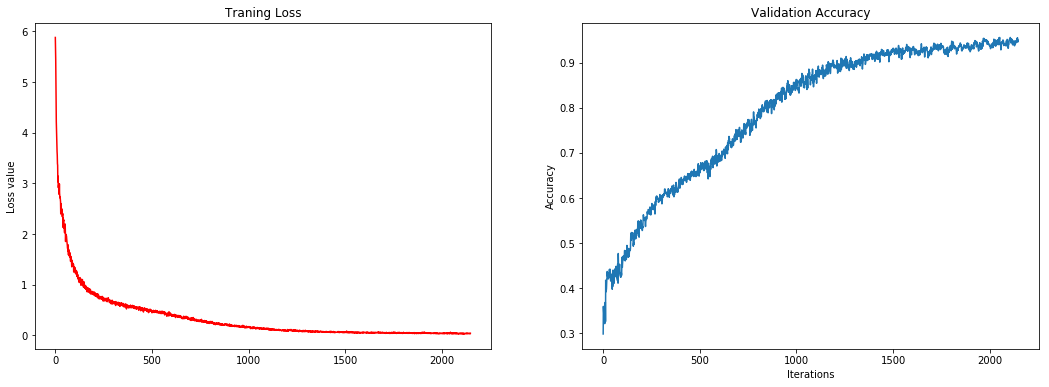

In [83]:
# Run the process again, we could have done this before, but didn't want to interfere with the 
# notebooks "protected" code.

# It would be even better with a graph:
# Visualize the loss and accuracy

"""
Graph it...!
"""
import matplotlib.pyplot as plt

import time


save_path = 'checkpoints/dev'
(source_int_text, target_int_text), (source_vocab_to_int, target_vocab_to_int), _ = helper.load_preprocess()
max_source_sentence_length = max([len(sentence) for sentence in source_int_text])

train_graph = tf.Graph()
with train_graph.as_default():
    input_data, targets, lr, keep_prob = model_inputs()
    sequence_length = tf.placeholder_with_default(max_source_sentence_length, None, name='sequence_length')
    input_shape = tf.shape(input_data)
    
    train_logits, inference_logits = seq2seq_model(
        tf.reverse(input_data, [-1]), targets, keep_prob, batch_size, sequence_length, len(source_vocab_to_int), len(target_vocab_to_int),
        encoding_embedding_size, decoding_embedding_size, rnn_size, num_layers, target_vocab_to_int)

    tf.identity(inference_logits, 'logits')
    with tf.name_scope("optimization"):
        # Loss function
        cost = tf.contrib.seq2seq.sequence_loss(
            train_logits,
            targets,
            tf.ones([input_shape[0], sequence_length]))

        # Optimizer
        optimizer = tf.train.AdamOptimizer(lr)

        # Gradient Clipping
        gradients = optimizer.compute_gradients(cost)
        capped_gradients = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gradients if grad is not None]
        train_op = optimizer.apply_gradients(capped_gradients)



def get_accuracy(target, logits):
    """
    Calculate accuracy
    """
    max_seq = max(target.shape[1], logits.shape[1])
    if max_seq - target.shape[1]:
        target = np.pad(
            target,
            [(0,0),(0,max_seq - target.shape[1])],
            'constant')
    if max_seq - logits.shape[1]:
        logits = np.pad(
            logits,
            [(0,0),(0,max_seq - logits.shape[1]), (0,0)],
            'constant')

    return np.mean(np.equal(target, np.argmax(logits, 2)))

train_source = source_int_text[batch_size:]
train_target = target_int_text[batch_size:]

valid_source = helper.pad_sentence_batch(source_int_text[:batch_size])
valid_target = helper.pad_sentence_batch(target_int_text[:batch_size])

#plotting info.....to graph
loss_list = []
valid_acc_list = []

with tf.Session(graph=train_graph) as sess:
    sess.run(tf.global_variables_initializer())

    for epoch_i in range(epochs):
        for batch_i, (source_batch, target_batch) in enumerate(
                helper.batch_data(train_source, train_target, batch_size)):
            start_time = time.time()
            
            _, loss = sess.run(
                [train_op, cost],
                {input_data: source_batch,
                 targets: target_batch,
                 lr: learning_rate,
                 sequence_length: target_batch.shape[1],
                 keep_prob: keep_probability})
            
            batch_train_logits = sess.run(
                inference_logits,
                {input_data: source_batch, keep_prob: 1.0})
            batch_valid_logits = sess.run(
                inference_logits,
                {input_data: valid_source, keep_prob: 1.0})
                
            train_acc = get_accuracy(target_batch, batch_train_logits)
            valid_acc = get_accuracy(np.array(valid_target), batch_valid_logits)
            end_time = time.time()

            # store our progress
            loss_list.append(loss) 
            valid_acc_list.append(valid_acc)
            
    print('Model Trained and Saved')
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    ax1.plot(loss_list, color='red')
    ax1.set_title('Traning Loss')

    ax1.set_ylabel('Loss value')
    ax2.plot(valid_acc_list)
    ax2.set_xlabel('Iterations')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Validation Accuracy')
    plt.show()